<a href="https://colab.research.google.com/github/rizkifrtma11/Capstone-Project-Bangkit-2024-batch-2/blob/main/Machine-Learning/klasifikasi-makanan/klasifikasi_makanan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pengembangan Model Klasifikasi Gambar untuk Klasifikasi Multiclass Project "RasaNusa" Menggunakan Arsitektur TensorFlow dan MobileNetV2**

Proyek ini mengembangkan dan mengimplementasikan model deep learning untuk klasifikasi gambar multiclass menggunakan arsitektur TensorFlow dan MobileNetV2. Dengan memanfaatkan teknik augmentasi data, transfer learning, serta evaluasi performa model.

**<h3>1. Import Package**

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from IPython.display import display, clear_output
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from google.colab import drive
import ipywidgets as widgets
import tensorflow as tf
from PIL import Image
import numpy as np
import io
import os

**<h3>2. Mount Google Drive**

In [6]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**<h3>3. Direktori Dataset**

In [7]:
TRAIN_DIR = '/content/drive/MyDrive/Machine-Learning/klasifikasi-makanan/data/train'
VALIDATION_DIR = '/content/drive/MyDrive/Machine-Learning/klasifikasi-makanan/data/valid'
TEST_DIR = '/content/drive/MyDrive/Machine-Learning/klasifikasi-makanan/data/test'

## **4. Konfigurasi Data dan Augmentasi**

In [8]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentasi dan pemrosesan dataset
def train_val_datasets():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.8, 1.2],
        channel_shift_range=20.0
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_dataset = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    validation_dataset = val_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    return train_dataset, validation_dataset

train_dataset, validation_dataset = train_val_datasets()

Found 1022 images belonging to 11 classes.
Found 89 images belonging to 11 classes.


**<h3>5. Create Model**

In [9]:
def create_model():
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(len(train_dataset.class_indices), activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )
    return model

classification_model = create_model()
classification_model.summary()

history_model = classification_model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,620,235 (10.00 MB)

 Trainable params: 2,217,355 (8.46 MB)

 Non-trainable params: 402,880 (1.54 MB)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 429s 10s/step - accuracy: 0.1387 - loss: 3.0697 - val_accuracy: 0.5169 - val_loss: 2.3819 - learning_rate: 1.0000e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 545ms/step - accuracy: 0.3991 - loss: 2.4193 - val_accuracy: 0.6966 - val_loss: 1.7400 - learning_rate: 1.0000e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 550ms/step - accuracy: 0.6181 - loss: 1.8592 - val_accuracy: 0.8539 - val_loss: 1.2910 - learning_rate: 1.0000e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 529ms/step - accuracy: 0.7655 - loss: 1.3667 - val_accuracy: 0.8315 - val_loss: 1.0918 - learning_rate: 1.0000e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 534ms/step - accuracy: 0.8240 - loss: 1.1587 - val_accuracy: 0.8427 - val_loss: 1.0516 - learning_rate: 1.0000e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 522ms/step - accuracy: 0.8834 - loss: 1.0178 - val_accuracy: 0.8876 - val_loss: 1.0040 - learning_rate: 1.0000e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 525ms/step - accuracy: 0.914

**<h3>6. Plot Training**

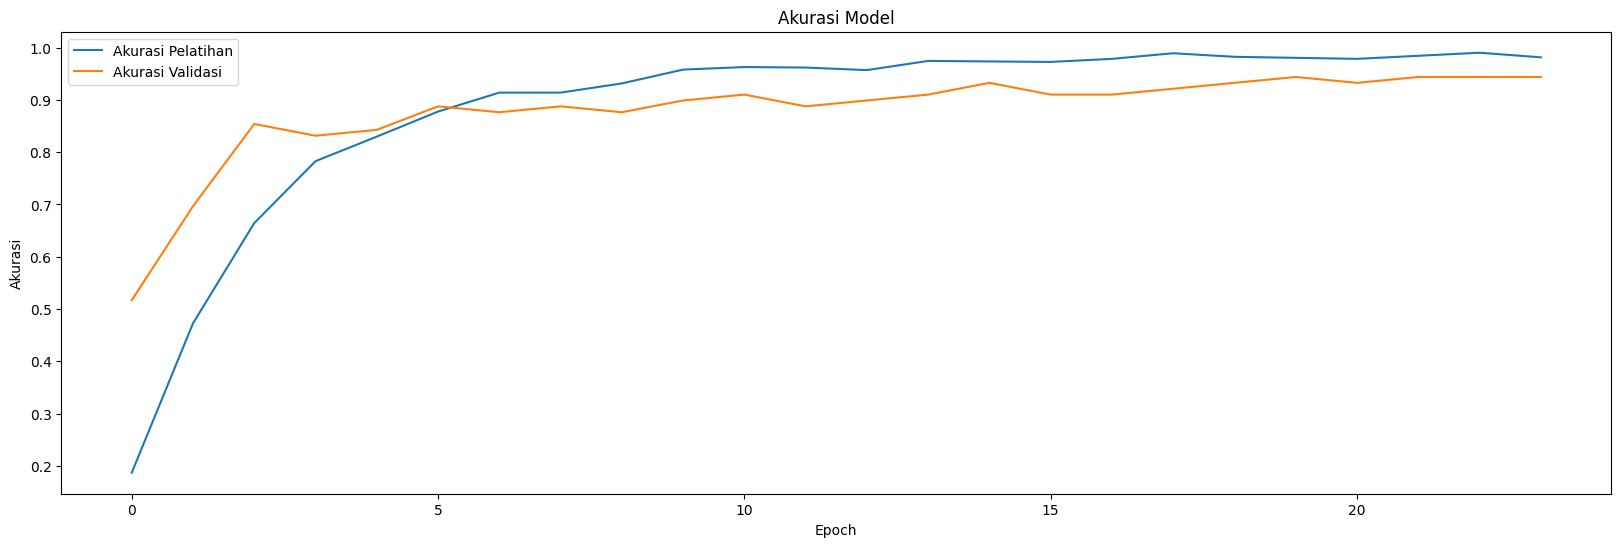

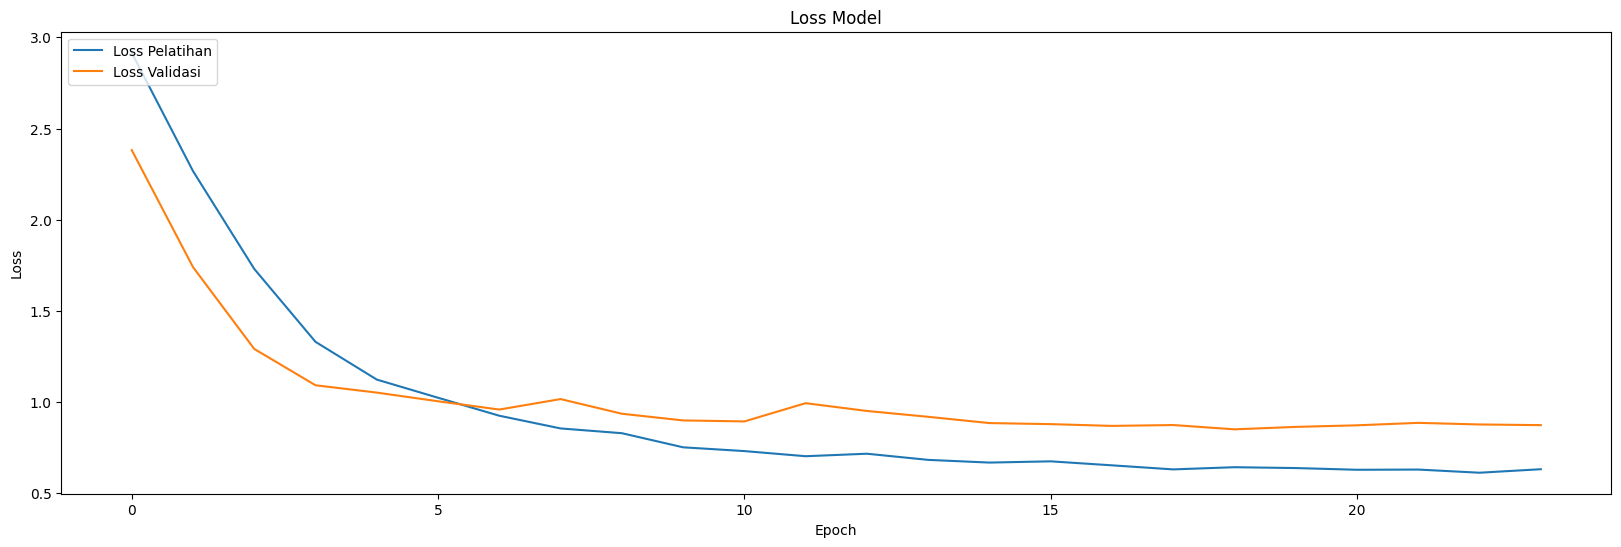

In [10]:
plt.figure(figsize=(20, 6))
plt.plot(history_model.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history_model.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(history_model.history['loss'], label='Loss Pelatihan')
plt.plot(history_model.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

**<h3>7. Save Model**

In [11]:
classification_model.save('/content/drive/MyDrive/Machine-Learning/klasifikasi-makanan/save-model/classification_model.keras')
# classification_model.save('classification_model.keras')


**<h3>8. Load Model**

In [12]:
classification_model = load_model('/content/drive/MyDrive/Machine-Learning/klasifikasi-makanan/save-model/classification_model.keras')
# classification_model = load_model('classification_model.keras')

**<h3>9. Fungsi load preprocess image and predict image**

In [13]:
def load_and_preprocess_image(uploaded_image):
    img = Image.open(io.BytesIO(uploaded_image['content']))
    img = img.convert('RGB')
    img = img.resize(IMAGE_SIZE)
    img = np.array(img)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def predict_from_test_folder(test_folder_path, model):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_folder_path,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False
    )

    predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
    predicted_class_indices = np.argmax(predictions, axis=1)
    class_labels = list(test_generator.class_indices.keys())
    predicted_class_names = [class_labels[i] for i in predicted_class_indices]

    for filename, class_name in zip(test_generator.filenames, predicted_class_names):
        print(f'File: {filename} -> Predicted Class: {class_name}')

predict_from_test_folder(TEST_DIR, classification_model)

Found 33 images belonging to 11 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step
File: 01. Kerak Telor/kerak-telor-12_jpg.rf.926782218c6fcf2a7cd0c273fc96cfca.jpg -> Predicted Class: 01. Kerak Telor
File: 01. Kerak Telor/kerak-telor-5_jpg.rf.eea991790e94450e61ca26856b6cac3e.jpg -> Predicted Class: 01. Kerak Telor
File: 02. Mie Aceh/Mie-Aceh-11_jpg.rf.3e335854e93515a60e2abe4b5e18467f.jpg -> Predicted Class: 02. Mie Aceh
File: 02. Mie Aceh/Mie-Aceh-1_jpg.rf.6a5499fdd491ed09bf7cbd290d27006e.jpg -> Predicted Class: 02. Mie Aceh
File: 02. Mie Aceh/Mie-Aceh-29_jpg.rf.b9b519e03d84a7085b371f5b209fb0f9.jpg -> Predicted Class: 02. Mie Aceh
File: 02. Mie Aceh/Mie-Aceh-38_jpg.rf.cd026f018439eda70553b97245d8263c.jpg -> Predicted Class: 02. Mie Aceh
File: 03. Papeda/Papeda-12_jpg.rf.8af1a74256153adae9b0cceb3398899c.jpg -> Predicted Class: 03. Papeda
File: 03. Papeda/Papeda-17_jpg.rf.42a155b59e064afc5db25a6ef3f45478.jpg -> Predicted Class: 03. Papeda
File: 03. Papeda/Papeda-6_jpg.rf.0b1a84104b3d77cd752b56

**<h3>10. Fungsi uploader**

In [15]:
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

def predict_image_with_threshold(uploader, model, threshold=0.6):
    if uploader.value:
        uploaded_image = list(uploader.value.values())[0]
        image = load_and_preprocess_image(uploaded_image)
        predictions = model.predict(image)
        max_prediction_confidence = np.max(predictions)

        if max_prediction_confidence < threshold:
            print("Data tidak tersedia di dataset")
        else:
            predicted_class = np.argmax(predictions, axis=1)
            class_labels = list(train_dataset.class_indices.keys())
            predicted_class_name = class_labels[predicted_class[0]]
            print(f"Predicted Class: {predicted_class_name} with confidence {max_prediction_confidence:.2f}")

predict_button = widgets.Button(description="Predict Image")
predict_button.on_click(lambda x: predict_image_with_threshold(uploader, classification_model))

# Display the button
display(predict_button)

FileUpload(value={}, accept='image/*', description='Upload')

Button(description='Predict Image', style=ButtonStyle())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Class: 07. Bika Ambon with confidence 1.00
